<a href="https://colab.research.google.com/github/AMIRMOHAMMAD-OSS/classi/blob/main/LLPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing libraries
!git clone https://github.com/AMIRMOHAMMAD-OSS/classi

from transformers import AutoTokenizer
from tqdm import tqdm
!pip install slack-sdk
from tqdm.contrib.slack import tqdm, trange
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import time
from collections import defaultdict
import torch
from torch.utils.data.dataloader import DataLoader
import time
import os
import sys
import json
import random
from ast import literal_eval
import numpy as np
import torch
from transformers import AutoTokenizer
from transformers import AutoTokenizer
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers
from transformers import CanineTokenizer, CanineModel
tokenizer = Tokenizer.from_file("classi/Trained_BPE2.json")
tokenizer.model_max_length = 256
tokenizer

from sklearn.preprocessing import StandardScaler as Sc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
import numpy as np

import torch

from sklearn.model_selection import train_test_split as TTS


def edit(x):
    for i in x:
      if i in "BJOUX\Z_n\n":
        x = x.replace(i,"")
      else:
        pass
    return x

def encode(x):
  l = []
  chars = tokenizer.get_vocab()
  for i in x:
    l.append(chars[i])
  return l

with open("classi/training.txt","r",encoding="utf-8") as f:
  text = f.read()
  k = "#".join([i for i in edit(text).split("<|edoftext|>")])
chars = tokenizer.get_vocab()
vocab_size = len(tokenizer.get_vocab())

with open("classi/validation.txt","r",encoding="utf-8") as f:
  text = f.read()
  l = "#".join([i for i in edit(text).split("<|edoftext|>")])

def Padding(x,PAD = 0,max_len = 512):
  l = []
  max_len = max(512,len(max(x,key = lambda x: len(x))))
  for i in x:
    a = i
    if len(a) < max_len:
      a = a + [PAD for i in range(max_len-len(a))]
    l.append(a)
  return np.array(l).reshape(len(x),max_len)
with open("classi/negative_dataset.txt") as x:
  c = x.read()
Filtered_train  = [i for i in k.split("#") if len(i)<= 512][1:]
Filtered_val = [i for i in l.split("#") if len(i)<= 512][1:]
Filtered_neg = [i for i in c.split("\n") if len(i)<= 512]
pos = Filtered_train + Filtered_val


Cloning into 'classi'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 14.07 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (12/12), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 6.3 MB/s eta 0:00:00


In [2]:
#@title Loading models and requierments

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def setup_logging(config):
    work_dir = config.system.work_dir
    os.makedirs(work_dir, exist_ok=True)
    with open(os.path.join(work_dir, 'args.txt'), 'w') as f:
        f.write(' '.join(sys.argv))
    with open(os.path.join(work_dir, 'config.json'), 'w') as f:
        f.write(json.dumps(config.to_dict(), indent=4))

class CfgNode:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __str__(self):
        return self._str_helper(0)

    def _str_helper(self, indent):
        parts = []
        for k, v in self.__dict__.items():
            if isinstance(v, CfgNode):
                parts.append("%s:\n" % k)
                parts.append(v._str_helper(indent + 1))
            else:
                parts.append("%s: %s\n" % (k, v))
        parts = [' ' * (indent * 4) + p for p in parts]
        return "".join(parts)

    def to_dict(self):
        return { k: v.to_dict() if isinstance(v, CfgNode) else v for k, v in self.__dict__.items() }

    def merge_from_dict(self, d):
        self.__dict__.update(d)

    def merge_from_args(self, args):

        for arg in args:
            keyval = arg.split('=')
            assert len(keyval) == 2, "expecting each override arg to be of form --arg=value, got %s" % arg
            key, val = keyval
            try:
                val = literal_eval(val)
            except ValueError:
                pass

            assert key[:2] == '--'
            key = key[2:]
            keys = key.split('.')
            obj = self
            for k in keys[:-1]:
                obj = getattr(obj, k)
            leaf_key = keys[-1]
            assert hasattr(obj, leaf_key), f"{key} is not an attribute that exists in the config"
            print("command line overwriting config attribute %s with %s" % (key, val))
            setattr(obj, leaf_key, val)

import math
import torch
import torch.nn as nn
from torch.nn import functional as F

class SiLU(nn.Module):
   def forward(self, x):
        return x*F.sigmoid(x)

class NY(nn.Module):
  def forward(self,x):
    return 3*torch.tanh(0.3*x)

class NewGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class ClassifierII(nn.Module):
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        C.vocab_size = len(chars)
        C.max_length = 512
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        self.max_length = config.block_size
        self.soft = nn.Softmax(1)
        self.config = self.get_default_config()
        self.device = "cuda"
        self.model_states = {'h':{'n_layer': 48, 'n_head': 25, 'n_embd': 1600},
                                    'g':{'n_layer': 12, '': 12, 'n_embd': 768},
                'f':   {'n_layer': 24, 'n_head': 16, 'n_embd': 1024},
                'e':   {'n_layer': 36, 'n_head': 20, 'n_embd': 1280},
                'd':{'n_layer': 8, 'n_head': 16, 'n_embd': 512},
                'c':{'n_layer': 6, 'n_head': 6, 'n_embd': 192},
                'b':{'n_layer': 4, 'n_head': 4, 'n_embd': 128},
                'a':{'n_layer': 3, 'n_head': 3, 'n_embd': 48}}

        type_ = config.model_type is not None
        #assert type_ in "abcdefgh"
        p = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        #assert type_ == True and p == True
        if type_:
            config.merge_from_dict(self.model_states[config.model_type])
        self.closs = nn.BCELoss()
        self.ny = NY()
        self.l = nn.Linear(512,1,64)
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.max_length, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.classifier_head = nn.Sequential(#nn.Tanh(),
                                             nn.Linear(config.n_embd, 2)
                                             )
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("[ Number of trainable parameters: %.2fM ]" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        from transformers import GPT2LMHeadModel
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 25
        config.max_length = 512
        model = ClassifierII(config)
        sd = model.state_dict()
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    def configure_optimizers(self, train_config):
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias'):
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    @torch.no_grad
    def predict_proba(self,idx,j ="None"):
      sigmoid = nn.Sigmoid()
      soft = nn.Softmax(dim=1)
      ny = NY()
      si = SiLU()
      self.eval()
      x,_ = self.forward(idx)
      if j == "None":
        return x[:,0:1]
      elif j == "soft":
        return self.soft(x)[:,0:1]
      else:
        return sigmoid(x)[:,0:1]

    @torch.no_grad
    def predict(self,idx):
      g = torch.zeros((idx.shape[0],1))
      e = -1
      for i in self.predict_proba(idx):
        e+=1
        if i[0].item()>=0.5:
          g[e] = 1
      return g

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.classifier_head(x).view(b,2,t).to(device)
        logits = self.l(logits)
        logits = F.sigmoid(self.ny(logits).view(b,2).mean(1).view(b,1))
        loss = None
        if targets is not None:
            loss = F.binary_cross_entropy(logits,targets)
        return logits, loss


class Trainer:
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.device = 'cuda'
        C.num_workers = 4
        C.max_iters = None
        C.batch_size = 128
        C.max_length = 512
        C.learning_rate = 8e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset,val_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.callbacks = defaultdict(list)
        self.device ='cuda'
        self.model = self.model.to(self.device)
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config
        self.optimizer = model.configure_optimizers(config)
        batch_size = self.config.batch_size
        def get_batch(mode):
            batch_size = 64
            if mode == "train":
              data = train_dataset
              pos_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]),513))
              neg_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]),513))
              N = np.random.randint(batch_size)
              ix_pos = np.random.randint(pos_train.shape[0]-N)
              ix_neg = np.random.randint(neg_train.shape[0]-batch_size-N)
              pos_data = pos_train[ix_pos:ix_pos+N,:]
              neg_data = neg_train[ix_neg:ix_neg+batch_size-N,:]
              data = torch.concat((pos_data,neg_data))
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,1), device="cuda")
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o] = 1
                #else:
                  #targets[o][1] = 1
            else:
              data = val_dataset
              ix = np.random.randint(data.shape[0]-batch_size)
              data = data[ix:ix+batch_size,:]
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,1), device="cuda")
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o] = 1
                #else:
                 # targets[o][1] = 1
            targets = targets.view(batch_size,1).to("cuda")
            seq = seq.view(batch_size,512).to("cuda")
            return seq, targets

        @torch.no_grad
        def cross_val():
          model.eval()
          out = []
          for i in ["train","val"]:
            losses = torch.zeros(200+1)
            for k in range(200):
              X,Y = get_batch(i)
              logits,loss = model(X,Y)
              losses[k]=loss.item()
              out1 = losses.mean()
            out.append(out1)
          model.train()
          return out
        losses = cross_val()
        LOSS = [losses]
        print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        model.train()
        for epoch in range(20):
          print("[epoch {o}] \n".format(o = epoch))
          iters = 200
          for i in range(iters):
            if i == 0:
              Y = "| ="
            elif i == iters -1 :
              Y = "=> 100% |"
            else:
              if i%(int(iters/50)) == 0 :
                Y = "="
              else:
                Y = ""
            print("{y}".format(y = Y),end="")
            x, y = get_batch("train")
            logits, self.loss = model(x, y)
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()
          losses = cross_val()
          LOSS.append(losses)
          print(LOSS)
          print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        PATH = "model {h}".format(h = model_config.model_type)
        torch.save(model.state_dict(), PATH)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def setup_logging(config):
    work_dir = config.system.work_dir
    os.makedirs(work_dir, exist_ok=True)
    with open(os.path.join(work_dir, 'args.txt'), 'w') as f:
        f.write(' '.join(sys.argv))
    with open(os.path.join(work_dir, 'config.json'), 'w') as f:
        f.write(json.dumps(config.to_dict(), indent=4))

class CfgNode:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __str__(self):
        return self._str_helper(0)

    def _str_helper(self, indent):
        parts = []
        for k, v in self.__dict__.items():
            if isinstance(v, CfgNode):
                parts.append("%s:\n" % k)
                parts.append(v._str_helper(indent + 1))
            else:
                parts.append("%s: %s\n" % (k, v))
        parts = [' ' * (indent * 4) + p for p in parts]
        return "".join(parts)

    def to_dict(self):
        return { k: v.to_dict() if isinstance(v, CfgNode) else v for k, v in self.__dict__.items() }

    def merge_from_dict(self, d):
        self.__dict__.update(d)

    def merge_from_args(self, args):

        for arg in args:
            keyval = arg.split('=')
            assert len(keyval) == 2, "expecting each override arg to be of form --arg=value, got %s" % arg
            key, val = keyval
            try:
                val = literal_eval(val)
            except ValueError:
                pass

            assert key[:2] == '--'
            key = key[2:]
            keys = key.split('.')
            obj = self
            for k in keys[:-1]:
                obj = getattr(obj, k)
            leaf_key = keys[-1]
            assert hasattr(obj, leaf_key), f"{key} is not an attribute that exists in the config"
            print("command line overwriting config attribute %s with %s" % (key, val))
            setattr(obj, leaf_key, val)

import math
import torch
import torch.nn as nn
from torch.nn import functional as F

class SiLU(nn.Module):
   def forward(self, x):
        return x*F.sigmoid(x)

class NY(nn.Module):
  def forward(self,x):
    return 3*torch.tanh(0.3*x)

class NewGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class ClassifierI(nn.Module):
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        C.vocab_size = len(chars)
        C.max_length = 512
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        self.max_length = config.block_size
        self.soft = nn.Softmax(1)
        self.config = self.get_default_config()
        self.device = "cpu"
        self.model_states = {'h':{'n_layer': 48, 'n_head': 25, 'n_embd': 1600},
                                    'g':{'n_layer': 12, '': 12, 'n_embd': 768},
                'f':   {'n_layer': 24, 'n_head': 16, 'n_embd': 1024},
                'e':   {'n_layer': 36, 'n_head': 20, 'n_embd': 1280},
                'd':{'n_layer': 8, 'n_head': 16, 'n_embd': 512},
                'c':{'n_layer': 6, 'n_head': 6, 'n_embd': 192},
                'b':{'n_layer': 4, 'n_head': 4, 'n_embd': 128},
                'a':{'n_layer': 3, 'n_head': 3, 'n_embd': 48}}

        type_ = config.model_type is not None
        #assert type_ in "abcdefgh"
        p = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        #assert type_ == True and p == True
        if type_:
            config.merge_from_dict(self.model_states[config.model_type])
        self.closs = nn.BCELoss()
        self.ny = NY()
        #self.l = nn.Linear(512,1,64)
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.max_length, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.classifier_head = nn.Sequential(#nn.Tanh(),
                                             nn.Linear(config.n_embd, 2)
                                             )
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        n_params = sum(p.numel() for p in self.transformer.parameters())
        #print("[ Number of trainable parameters: %.2fM ]" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        from transformers import GPT2LMHeadModel
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 25
        config.max_length = 512
        model = ClassifierI(config)
        sd = model.state_dict()
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    def configure_optimizers(self, train_config):
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias'):
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    @torch.no_grad
    def predict_proba(self,idx,j ="None"):
      sigmoid = nn.Sigmoid()
      soft = nn.Softmax(dim=1)
      ny = NY()
      si = SiLU()
      self.eval()
      x,_ = self.forward(idx)
      if j == "None":
        return x[:,0:1]
      elif j == "soft":
        return self.soft(x)[:,0:1]
      else:
        return sigmoid(x)[:,0:1]

    @torch.no_grad
    def predict(self,idx):
      g = torch.zeros((idx.shape[0],1))
      e = -1
      for i in self.predict_proba(idx):
        e+=1
        if i[0].item()>=0.5:
          g[e] = 1
      return g

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.ny(self.classifier_head(x)).mean(1).to(device)
        #logits = self.l(logits)
        # = F.sigmoid(logits.view(b,2).mean(1).view(b,1))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits,targets,ignore_index = -1)
        return logits, loss


class Trainer:
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.device = 'cuda'
        C.num_workers = 4
        C.max_iters = None
        C.batch_size = 64
        C.max_length = 512
        C.learning_rate = 8e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset,val_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.callbacks = defaultdict(list)
        self.device ='cuda'
        self.model = self.model.to(self.device)
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config
        self.optimizer = model.configure_optimizers(config)
        batch_size = self.config.batch_size
        def get_batch(mode):
            batch_size = 64
            if mode == "train":
              data = train_dataset
              pos_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]),513))
              neg_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]),513))
              N = np.random.randint(batch_size)
              ix_pos = np.random.randint(pos_train.shape[0]-N)
              ix_neg = np.random.randint(neg_train.shape[0]-batch_size-N)
              pos_data = pos_train[ix_pos:ix_pos+N,:]
              neg_data = neg_train[ix_neg:ix_neg+batch_size-N,:]
              data = torch.concat((pos_data,neg_data))
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,2), device=self.device)
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o][0] = 1
                else:
                  targets[o][1] = 1
            else:
              data = val_dataset
              ix = np.random.randint(data.shape[0]-batch_size)
              data = data[ix:ix+batch_size,:]
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,2), device=self.device)
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o][0] = 1
                else:
                  targets[o][1] = 1
            targets = targets.view(batch_size,2).to(self.device)
            seq = seq.view(batch_size,512).to(self.device)
            return seq, targets

        @torch.no_grad
        def cross_val():
          model.eval()
          out = []
          for i in ["train","val"]:
            losses = torch.zeros(200+1)
            for k in range(200):
              X,Y = get_batch(i)
              logits,loss = model(X,Y)
              losses[k]=loss.item()
              out1 = losses.mean()
            out.append(out1)
          model.train()
          return out
        losses = cross_val()
        LOSS = [losses]
        print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        model.train()
        for epoch in range(20):
          print("[epoch {o}] \n".format(o = epoch))
          iters = 200
          for i in range(iters):
            if i == 0:
              Y = "| ="
            elif i == iters -1 :
              Y = "=> 100% |"
            else:
              if i%(int(iters/50)) == 0 :
                Y = "="
              else:
                Y = ""
            print("{y}".format(y = Y),end="")
            x, y = get_batch("train")
            logits, self.loss = model(x, y)
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()
          losses = cross_val()
          LOSS.append(losses)
          print(LOSS)
          print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        PATH = "model {h}".format(h = model_config.model_type)
        torch.save(model.state_dict(), PATH)
class Transformer():
  def __init__(self,mode):
    self.mode = mode
    self.device = torch.device("cuda")
    self.vocab_dict = tokenizer.get_vocab()

  def classifier(self):
    device = self.device
    model_config = ClassifierI.get_default_config()
    model_config = ClassifierI.get_default_config()
    model_config.vocab_size = 25
    model_config.block_size = 512
    if self.mode == "b":
      model_config.model_type = 'b'
      model2 = ClassifierI(model_config)
      model2.load_state_dict(torch.load("classi/model_b",map_location=self.device))
    else:
      model_config.model_type = 'c'
      model2 = ClassifierI(model_config)
      model2.load_state_dict(torch.load("classi/model_c",map_location = self.device))
    model2.to(device)
    return model2
  def Encode(self,i):
    def encode(x):
      l = []
      chars = self.vocab_dict
      for i in x:
        l.append(chars[i])
      return l
    def Padding(x,PAD = 0,max_len = 512):
      l = []
      max_len = 512
      for i in x:
        a = i
        if len(a) < max_len:
          a = a + [PAD for i in range(max_len-len(a))]
        l.append(a)
      return np.array(l).reshape(len(x),max_len)

    return  torch.tensor(Padding(list(map(encode,i)))).view(len(i),512).to(self.device)

  def Decode(self,i):
    def decode(k):
      l = [j for j in k if j != 0 ]
      seq = [chars[j] for j in l]
      return "".join(seq)
    H = list(map(decode,i))
    G = []
    for i in H:
      if len(i)>512:
        u = H.index(i)
        for j in range(len(i)-512):
          G.append(i[j:j+512])
      else:
        G.append(i)
    return G,u
  def Mean(self,i):
    I = list(i.ravel())
    sig = lambda x:np.e**(0*x)
    Sum = [sig(np.abs(x-int(len(I)/2))) for x in range(len(I))]
    wei = np.array([Sum[i]/sum(Sum) for i in range(len(I))]).reshape(len(I),1)
    return np.sum(wei*i)

  def enhancer(self,x):
    wei = np.array([np.exp((i[0]-1)/(i[0])) for i in x])
    return np.sum(np.array([i[0] for i in x])*wei)/np.sum(wei)

  def predict_proba(self,i):
    if len(i[0])>512:
       l = [self.Encode([i[0][j:j+512]]) for j in range(len(i[0])-512)]
       if len(l)>700:
        L = [torch.concat(tuple(l[i*700:(i+1)*700])) for i in range(len(l)//700)] + [torch.concat(tuple(l[(len(l)//700)*700:(len(l)//700)*700+len(l)%700]))]
        T = [self.classifier().predict_proba(i,"sig").tolist() for i in L ]
        return self.enhancer(np.concatenate(tuple([i for i in T])))
       else:
         t = torch.concat(tuple(l))
         return self.enhancer(self.classifier().predict_proba(t,"sig").tolist())
    else:
       seq = self.Encode(i)
       U = np.array(self.classifier().predict_proba(seq,"sig").tolist())
       out = np.array(U)
       return out.reshape(len(i),1)

model2 = Transformer("b")
model3 = Transformer("c")


import functools as FUNC
from numba import njit
class PPA():
    def __init__(self, seq, model):
        self.model = model
        self.seq = seq
        self.s = None
        self.len = len(self.seq)
        self.idx = None
        self.p = None
        self.dir = None
        self.name = None

    def attention_mask(self):
        idx2 = self.Splicer(self.seq)[1]
        k = self.T()
        mask = []
        for j in range(len(k)):
           mask.append([True if len(k[0])>idx2[j]-i>-1 else False for i in range(len(k[j]))])
        return mask

    def Mean(self, mask, spliced):
       u = []
       for i in trange(len(spliced)):
          o = self.model.predict_proba([spliced[i][j] for j in range(len(spliced[i])) if mask[i][j] == True])
          u.append(np.mean(o))
       return u

    def SPLICE_scorer(self, i):
        o = []
        lmin = int(np.floor(len(i)/2))
        lmax = int(np.ceil(len(i)/2))
        for j in range(len(i) - lmin+1):
            o.append(i[j:j + lmin])
        return o

    def Splicer(self, i):
        o = []
        Before = []
        idx = self.idx
        for j in range(len(i)):
            n_b = j
            n_a = len(i) - j - 1
            if n_b <= int(np.floor(idx/2)):
                before = i[j - min(int(np.floor(idx/2)), n_b):j]
                after = i[j + 1:j + idx - len(before)]
            elif n_a <= int(np.ceil(idx/2)):
                before = i[j - idx + n_a+1:j]
                after = i[j + 1:]
            else:
                before = i[j - min(int(np.floor(idx/2)), n_b):j]
                after = i[j + 1:j + min(int(np.ceil(idx/2)), n_a)]
            o.append(before + i[j] + after)
            Before.append(len(before))
        return o,Before

    def T(self):
        return list(map(self.SPLICE_scorer, self.Splicer(self.seq)[0]))

    def Out(self):
        def d(x):
            if self.s>0.7:
                return x*np.exp(-1.2*(x-self.s))
            else:
                if x > 0.7 :
                    return x
                else:
                    #x * np.exp(-2 * np.abs(x - self.s))
                    return x
        return list(map(d,self.Mean(self.attention_mask(),self.T())))



    def show(self,name:str):
        import matplotlib.pyplot as plt
        i = self.p
        values = np.array(i).reshape(1, len(i))
        y = range(len(i))
        Y = [(j,1) for j in range(len(i)) if np.mean([i[j],i[min((j+1),len(i)-1)],i[max(0,(j-1))]])>0.6]
        Y2 = [(j,1) for j in range(len(i)) if np.mean([i[j],i[min((j+1),len(i)-1)],i[min((j+2),len(i)-1)],i[min((j+3),len(i)-1)],i[min((j+4),len(i)-1)],i[min((j+5),len(i)-1)],i[max(0,(j-1))],i[max(0,(j-2))],i[max(0,(j-3))],i[max(0,(j-4))],i[max(0,(j-5))]])>0.85]
        threshold = 0.5
        above_threshold = np.maximum(values - threshold, 0)
        below_threshold = np.minimum(values, threshold)
        fig, (ax3 , ax4) = plt.subplots(2,1,sharex = True,sharey = True)
        ax3.bar(y, below_threshold.ravel(), 0.9, color="lightblue")
        ax3.bar(y, above_threshold.ravel(), 0.9, color="lightgreen",
               bottom=below_threshold.ravel())
        ax4.broken_barh(Y, (0.7, 0.03),
               facecolors=( 'red'))
        ax4.plot([0., y[-1]],[0.715,0.715],"-b")
        for k in Y:
            ax4.plot([k[0],k[0]+1],[0.715,0.715],"-r")

        ax4.text(0,0.8 , "LLPS-susceptible regions",fontsize = 20)
        ax3.plot([0., y[-1]], [threshold, threshold], "k--")
        ax4.set_ylim([0,1])
        ax3.set_ylim([0,1])

        plt.subplots_adjust(
                    wspace=0.4,
                    hspace=0)
        fig.set_figwidth(20)
        fig.set_figheight(15)
        plt.show()
        if self.dir != None:
          if self.name != None:
            fig.savefig(self.dir+"\\"+self.name)
          else:
            name = np.random.randint(1000000)
            fig.savefig(self.dir+"\\"+"figure,sequenceID:"+str(name)+".png")


The request to the Slack API failed. (url: https://www.slack.com/api/chat.postMessage)
The server responded with: {'ok': False, 'error': 'not_authed'}


  0%|          | 0/96 [00:00<?, ?it/s]

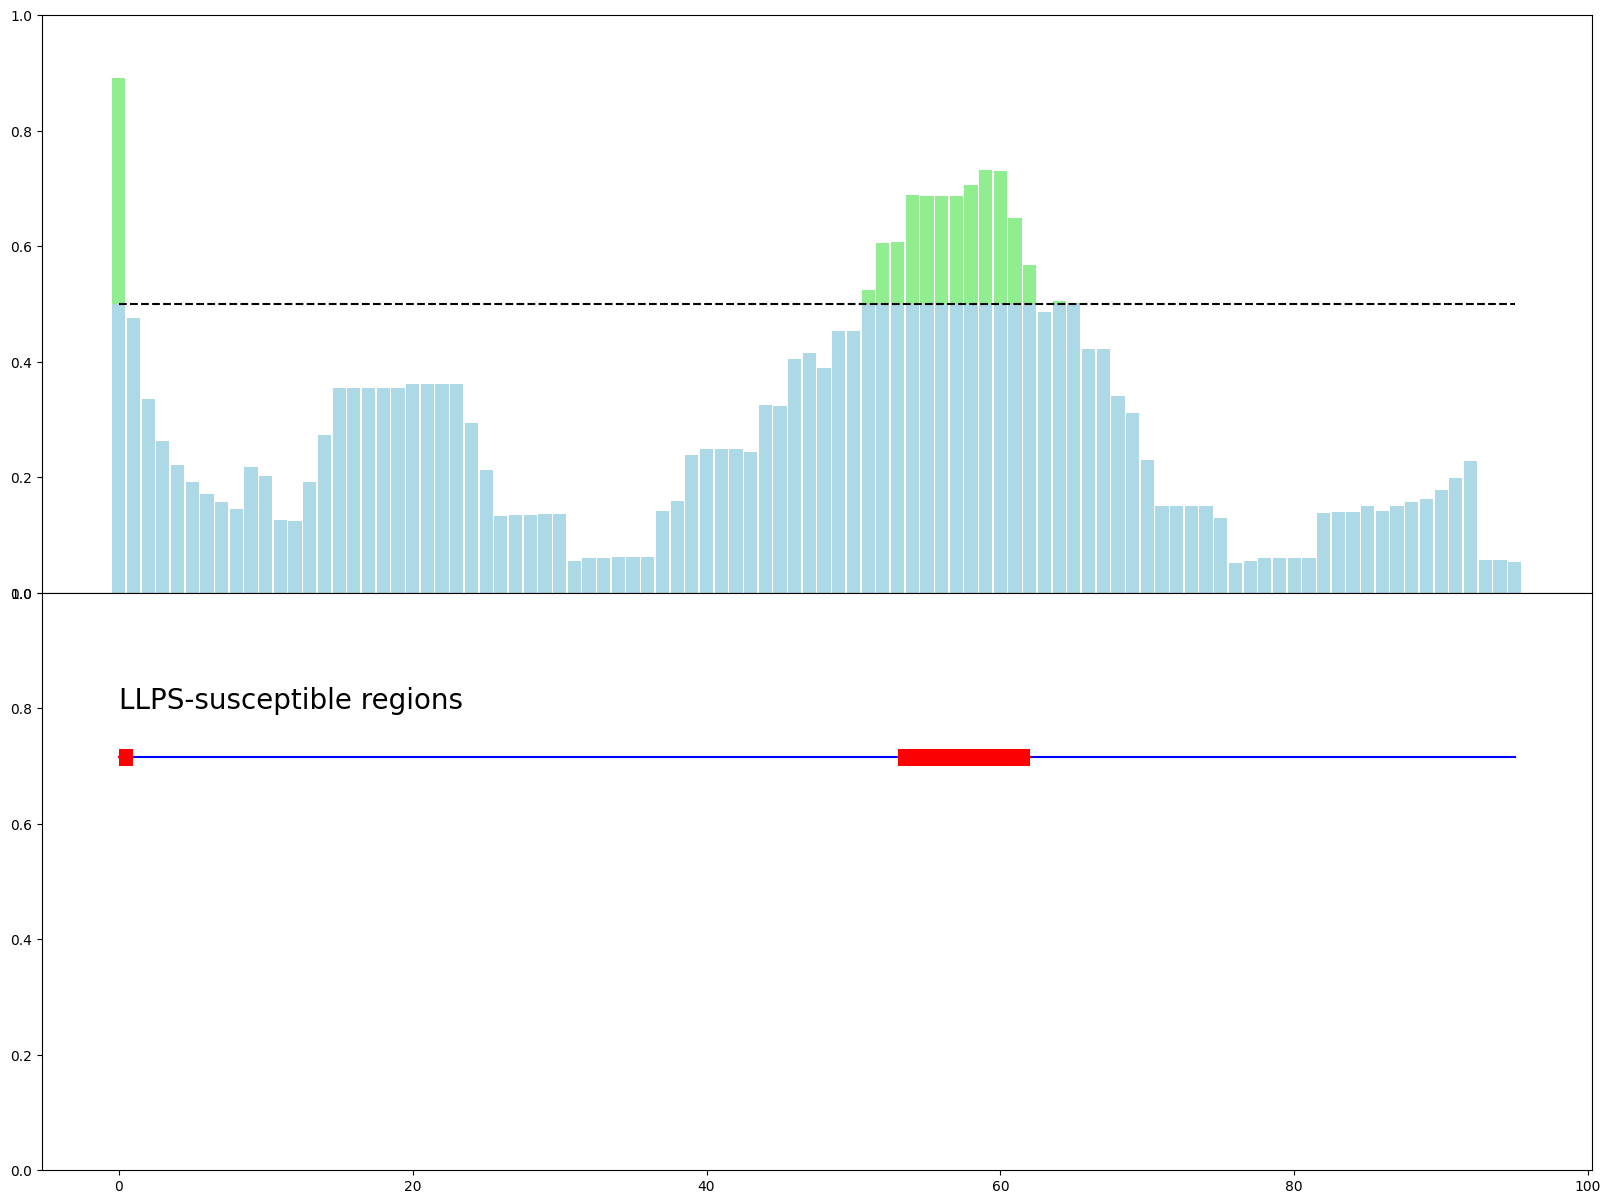

Score : [[0.30924762]]


In [106]:
#@title Loading sequence , then hit `Runtime` -> `Run all`
Sequence = "YTSLNHSLIEEIQWQQEKNFQELLEKYKWKSLWRWWASEPNQSLPVNDPRSEQKPPKSESKGIVQQQNDLLDAIEAQQHLLQLTVWGIKQLQARVL" #@param {type:"string"}
name = None #@param {type:"string"}
directory = None #@param {type:"string"}
def enh(x):
  wei = np.array([np.exp((i-1)/(i)) for i in x])
  return np.sum(np.array(x)*wei)/np.sum(wei)

def edit(i):
  for j in i:
    if j in "\t\n ":
      i = i.replace(j,"")
  return i
Sequence = edit(Sequence)

u = model3.predict_proba([Sequence])

c = PPA(Sequence,model3)
c.s = np.mean(u)
c.idx = 20
#int(np.ceil(0.1*len(Sequence)))
p = c.Out()
c.p = p
c.dir = directory
c.name = name
c.show("l")
print("Score : "+str((2*u+2*enh(p))/4))

In [99]:
model3.predict_proba(["MATRIAILGAGPSGMAQLRAFQSAQEKGAEIPELVCFEKQADWGGQWNYTWRTGLDENGEPVHSSMYRYLWSNGPKECLEFADYTFDEHFGKPIASYPPREVLWDYIKGRVEKAGVRKYIRFNTAVRHVEFNEDSQTFTVTVQDHTTDTIYSEEFDYVVCCTGHFSTPYVPEFEGFEKFGGRILHAHDFRDALEFKDKTVLLVGSSYSAEDIGSQCYKYGAKKLISCYRTAPMGYKWPENWDERPNLVRVDTENAYFADGSSEKVDAIILCTGYIHHFPFLNDDLRLVTNNRLWPLNLYKGVVWEDNPKFFYIGMQDQWYSFNMFDAQAWYARDVIMGRLPLPSKEEMKADSMAWREKELTLVTAEEMYTYQGDYIQNLIDMTDYPSFDIPATNKTFLEWKHHKKENIMTFRDHSYRSLMTGTMAPKHHTPWIDALDDSLEAYLSDKSEIPVAKEAGSGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGGGAGHVPEYFVGIGTPISFYGHHHHHHHHHHHHHHHHHHHHHHHHGGAGHVPEYFVGIGTPISFYGENFKHLPEPFRIRVIEPVKRTTRAYREEAIIKSGMNPFLLDSEDVFIDLLTDSGTGAVTQSMQAAMMRGDEAYSGSRSYYALAESVKNIFGYQYTIPTHQGRGAEQIYIPVLIKKREQEKGLDRSKMVAFSNYFFDTTQGHSQINGCTVRNVYIKEAFDTGVRYDFKGNFDLEGLERGIEEVGPNNVPYIVATITSNSAGGQPVSLANLKAMYSIAKKYDIPVVMDSARFAENAYFIKQREAEYKDWTIEQITRETYKYADMLAMSAKKDAMVPMGGLLCMKDDSFFDVYTECRTLCVVQEGFPTYGGLEGGAMERLAVGLYDGMNLDWLAYRIAQVQYLVDGLEEIGVVCQQAGGHAAFVDAGKLLPHIPADQFPAQALACELYKVAGIRAVEIGSFLLGRDPKTGKQLPCPAELLRLTIPRATYTQTHMDFIIEAFKHVKENAANIKGLTFTYEPKVLRHFTAKLKEV"])

0.756029666760937

In [107]:
enh(p),np.mean(p)

(0.5606659435139937, 0.28297123235360083)

In [6]:
Filtered_train  = [i for i in k.split("#") ][1:]
Filtered_val = [i for i in l.split("#") ][1:]
Filtered_neg = [i for i in c.split("\n")]
pos = Filtered_train + Filtered_val

AttributeError: 'PPA' object has no attribute 'split'

In [ ]:
len(pos)

In [ ]:
S = [model3.predict_proba([i]) for i in tqdm(pos)]

In [ ]:
with open("AA.txt","w") as d:
  for i in S:
    d.write(str(i)+"\n")

In [ ]:
neg = [model3.predict_proba([i]) for i in tqdm(Filtered_neg)]
with open("AAA.txt","w") as d:
  for i in neg:
    d.write(str(i)+"\n")

In [ ]:
with open("negative_dataset (2).txt") as x:
  c = x.read()

In [ ]:
Filtered_neg = [i for i in c.split("\n")]


In [ ]:
len(Filtered_neg)